In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import re
import ast
from collections import defaultdict
from tqdm import tqdm

## Opening anaylsis

In [3]:
player_to_analyze = "peterchero"

In [4]:
cm = pd.read_csv("21henchen_games_data.csv")
cm

,Event,Site,Date,White,Black,Result,WhiteElo,BlackElo,ECO,Opening,Termination,Moves,Evaluation
0,ACLVB Open Chess Tournament - Round 1,Chess.com,2018.01.17,21chenhen,jamesst87,1-0,874,1074,B12,B12,21chenhen won by resignation,"['e2e4', 'c7c6', 'd2d4', 'd7d5', 'e4e5', 'c8f5...","[{'player': 'White', 'move_number': 1, 'move':..."
1,Live Chess,Chess.com,2023.03.09,AshuL4,21chenhen,1/2-1/2,1578,1471,B34,B34,Game drawn by repetition,"['e2e4', 'c7c5', 'g1f3', 'g7g6', 'd2d4', 'c5d4...","[{'player': 'White', 'move_number': 1, 'move':..."
2,Live Chess,Chess.com,2018.01.09,21chenhen,alton_mies,0-1,877,771,C00,C00,alton_mies won by checkmate,"['e2e4', 'd7d5', 'b1c3', 'e7e6', 'd1e2', 'f8d6...","[{'player': 'White', 'move_number': 1, 'move':..."
3,Live Chess,Chess.com,2023.01.21,koza1987,21chenhen,1-0,1289,1290,B20,B20,koza1987 won on time,"['e2e4', 'c7c5', 'c2c4', 'g7g6', 'd2d3', 'f8g7...","[{'player': 'White', 'move_number': 1, 'move':..."
4,Let's Play,Chess.com,2020.10.06,21chenhen,micktasty,1-0,851,777,A01,A01,21chenhen won on time,"['b2b3', 'c7c5', 'c1b2', 'e7e6', 'f2f4', 'c5c4...","[{'player': 'White', 'move_number': 1, 'move':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,Live Chess,Chess.com,2020.09.30,manuelperez2020,21chenhen,1-0,988,995,B12,B12,manuelperez2020 won by checkmate,"['d2d4', 'd7d5', 'b1c3', 'g8f6', 'f2f3', 'c7c6...","[{'player': 'White', 'move_number': 1, 'move':..."
1512,Live Chess,Chess.com,2024.06.03,Bigwillicious,21chenhen,0-1,1437,1432,B00,B00,21chenhen won by resignation,"['e2e4', 'b7b6', 'f2f4', 'c8b7', 'e4e5', 'e7e6...","[{'player': 'White', 'move_number': 1, 'move':..."
1513,Live Chess,Chess.com,2022.10.17,21chenhen,KingKullar,0-1,871,968,A01,A01,KingKullar won by checkmate,"['b2b3', 'd7d5', 'c1b2', 'b8c6', 'e2e3', 'e7e5...","[{'player': 'White', 'move_number': 1, 'move':..."
1514,Live Chess,Chess.com,2024.05.20,21chenhen,Cesarcossani,1-0,1483,1414,A01,A01,21chenhen won by checkmate,"['b2b3', 'e7e5', 'c1b2', 'e5e4', 'f2f3', 'e4f3...","[{'player': 'White', 'move_number': 1, 'move':..."


### Convert tags to numerical values

In [27]:
cm["Event"] = cm["Event"].replace({"Casual": 0, "Rated": 1})

In [29]:
def get_player_result(row):
    if row['Result'] == '1-0':
        if row['White'] == player_to_analyze:
            return 1  # Player won as White
        elif row['Black'] == player_to_analyze:
            return 0  # Player lost as Black
    elif row['Result'] == '0-1':
        if row['Black'] == player_to_analyze:
            return 1  # Player won as Black
        elif row['White'] == player_to_analyze:
            return 0  # Player lost as White
    elif row['Result'] == '1/2-1/2':
        return 0.5  # Draw
    else:
        return None  # Undefined result

cm['Result'] = cm.apply(get_player_result, axis=1)

In [31]:
def get_event_type(row):
    if type(row['Event']) == int:
        return row['Event']
    if "Casual" in row['Event']:
        return 0
    else:
        return 1
cm['Event'] = cm.apply(get_event_type, axis=1)

In [33]:
competetive_games = cm[cm["Event"] == 1]

In [35]:
allOpenings = cm['ECO'].value_counts().to_dict()

### Convert ECO to opening names

In [38]:
file = open('eco_codes.txt')
ECO_codes = file.read()

def parse_eco_codes(inputfile):
    eco_dict = {}
    lines = inputfile.strip().split('\n')
    for line in lines:
        # Use regex to match lines starting with an ECO code followed by a tab and the opening name
        match = re.match(r'^([A-E][0-9]{2})\t(.+)$', line)
        if match:
            eco_code = match.group(1)
            opening_name = match.group(2)
            eco_dict[eco_code] = opening_name
    return eco_dict

# Example: Translate an ECO code to its opening name
def eco_to_opening(row):
    eco_code = row['ECO']
    opening_name = eco_codes_dict.get(eco_code, "Unknown ECO code")
    return opening_name

# Parse the input text
eco_codes_dict = parse_eco_codes(ECO_codes)

cm['Opening'] = cm['ECO']
cm['Opening'] = cm.apply(eco_to_opening, axis = 1)

### Plotting data

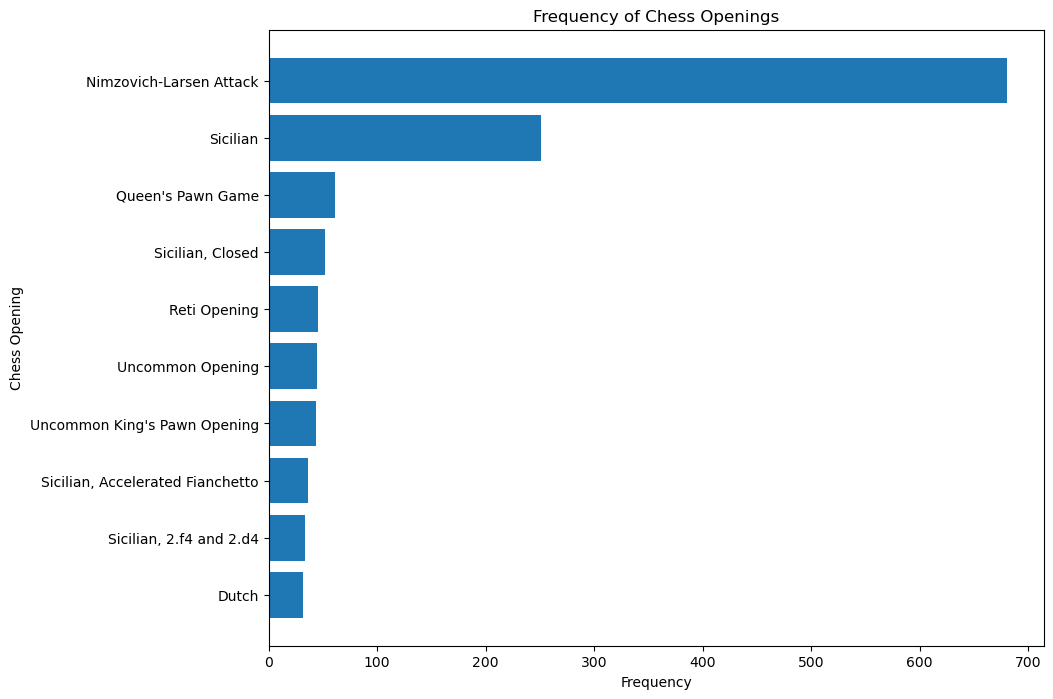

In [41]:
allOpenings = cm['Opening'].value_counts().to_dict()

min_instances = 20

filtered_openings = dict(
    filter(lambda item: min_instances <= int(item[1]), allOpenings.items())
)


openings = np.array(list(filtered_openings.keys()))
frequencies = np.array(list(filtered_openings.values()))

# Sort data by frequency for better visualization
sorted_indices = np.argsort(frequencies)
openings = openings[sorted_indices]
frequencies = frequencies[sorted_indices]

# Plot the bar chart
plt.figure(figsize=(10, 8))
plt.barh(openings, frequencies)
plt.xlabel('Frequency')
plt.ylabel('Chess Opening')
plt.title('Frequency of Chess Openings')
plt.show()

In [43]:
allOpenings.keys()

total_count = sum(allOpenings.values())
opening_percentages = {opening: (count / total_count) * 100 for opening, count in allOpenings.items()}

'''
openings = np.array(list(opening_percentages.keys()))
frequencies = np.array(list(opening_percentages.values()))

# Sort data by frequency for better visualization

sorted_indices = np.argsort(frequencies)
openings = openings[sorted_indices]
frequencies = frequencies[sorted_indices]

# Plot the bar chart

plt.figure(figsize=(10, 8))
plt.barh(openings, frequencies)
plt.xlabel('Frequency')
plt.ylabel('Chess Opening')
plt.title('Frequency of Chess Openings')
plt.show()
'''

"\nopenings = np.array(list(opening_percentages.keys()))\nfrequencies = np.array(list(opening_percentages.values()))\n\n# Sort data by frequency for better visualization\n\nsorted_indices = np.argsort(frequencies)\nopenings = openings[sorted_indices]\nfrequencies = frequencies[sorted_indices]\n\n# Plot the bar chart\n\nplt.figure(figsize=(10, 8))\nplt.barh(openings, frequencies)\nplt.xlabel('Frequency')\nplt.ylabel('Chess Opening')\nplt.title('Frequency of Chess Openings')\nplt.show()\n"

In [45]:
henrydf

NameError: name 'henrydf' is not defined

## Move interpretation

### Move Bucketing

In [49]:
#cms = pd.read_csv("full_combined_games_data.csv")
#cms

**We can group our data so that the CPL of a given move can evaluated in comparison to the CPL of other games at that same move. Given this, we can understand weak points in our game. For example, move 1 would be hard to mess up on, since there are very few mistakes to be had at the first move of a chess game, so we should expect there to be a lower average CPL on move 1 of our game.**

In [264]:
from collections import defaultdict
import ast

def moveBucketAnalysis(playerName, data):
    player_move_bucket = defaultdict(float)    # Sum of centipawn losses per move
    player_move_count = defaultdict(int)       # Count of moves per move
    player_move_cpl_list = defaultdict(list)   # List of centipawn losses per move
    best_move_bucket = defaultdict(int)        # Sum of best move counts per move

    for game in range(len(data)):
        # Extract the list of dictionaries (move evaluations)
        evaluations = data['Evaluation'][game]
        evaluations = ast.literal_eval(evaluations)
        
        # Initialize move counters
        white_moves = 0
        black_moves = 0
        
        # Loop through each move evaluation
        for move_eval in evaluations:
            player = move_eval['player']
            centipawn_loss = move_eval['centipawn_loss']
            
            # Process data as needed
            if player == 'White':
                if playerName == data['White'][game]:
                    white_moves += 1
                    move_number = white_moves
                    player_move_bucket[move_number] += centipawn_loss
                    player_move_count[move_number] += 1
                    player_move_cpl_list[move_number].append(centipawn_loss)
                    if centipawn_loss < 1:
                        best_move_bucket[move_number] += 1 
            else:
                if playerName == data['Black'][game]:
                    black_moves += 1
                    move_number = black_moves
                    player_move_bucket[move_number] += centipawn_loss
                    player_move_count[move_number] += 1
                    player_move_cpl_list[move_number].append(centipawn_loss)
                    if centipawn_loss < 1:
                        best_move_bucket[move_number] += 1 

    # Calculate average centipawn loss and error margins per move number
    avg_move_cpl = {}
    error_margin_cpl = {}
    avg_move_bmc = {}
    
    for move_number in player_move_bucket:
        total_cpl = player_move_bucket[move_number]
        count = player_move_count[move_number]
        avg_cpl = total_cpl / count if count > 0 else 0
        avg_move_cpl[move_number] = avg_cpl
        
        # Calculate error margin
        cpl_list = player_move_cpl_list[move_number]
        mean = avg_cpl
        variance = sum((x - mean) ** 2 for x in cpl_list) / (count - 1) if count > 1 else 0
        std_dev = variance ** 0.5
        error_margin_cpl[move_number] = std_dev / math.sqrt(count)
    
    for move_number in player_move_bucket:
        total_bmc = best_move_bucket[move_number]
        count = player_move_count[move_number]
        avg_bmc = total_bmc / count if count > 0 else 0
        avg_move_bmc[move_number] = avg_bmc

    return [playerName, dict(avg_move_cpl), dict(player_move_count), dict(error_margin_cpl), dict(avg_move_bmc)]

In [266]:
petes_moves = moveBucketAnalysis("peterchero", cm)
henry = pd.read_csv("21henchen_games_data.csv")
henrys_moves = moveBucketAnalysis("21chenhen", henry)

In [270]:
henry = pd.read_csv("21henchen_games_data.csv")
#henrys_moves[4]
henrys_moves[4]

{1: 0.18890356671070013,
 2: 0.40159045725646125,
 3: 0.322,
 4: 0.2716879623402825,
 5: 0.27611940298507465,
 6: 0.2727272727272727,
 7: 0.2697866483138334,
 8: 0.24324324324324326,
 9: 0.25912921348314605,
 10: 0.2556980056980057,
 11: 0.24281609195402298,
 12: 0.24383164005805516,
 13: 0.2558997050147493,
 14: 0.2745686421605401,
 15: 0.23129770992366414,
 16: 0.2782540919719408,
 17: 0.26282051282051283,
 18: 0.27346938775510204,
 19: 0.28690575479566305,
 20: 0.27429062768701634,
 21: 0.29521276595744683,
 22: 0.29853479853479853,
 23: 0.27136150234741785,
 24: 0.3125,
 25: 0.290519877675841,
 26: 0.2955288985823337,
 27: 0.285385500575374,
 28: 0.2991556091676719,
 29: 0.30798479087452474,
 30: 0.303595206391478,
 31: 0.2743732590529248,
 32: 0.3377386196769457,
 33: 0.33075734157650694,
 34: 0.3168,
 35: 0.3202725724020443,
 36: 0.3471971066907776,
 37: 0.36538461538461536,
 38: 0.336734693877551,
 39: 0.3227176220806794,
 40: 0.3691275167785235,
 41: 0.3547619047619048,
 42: 0.

In [288]:
henrydf = pd.DataFrame(henrys_moves)
henrydf
henrydf.to_csv('henrydata.csv', index=False)

**ELO Rating estimation for Humans = 3100(e^(-0.01(Average Centipawn Loss))).**

In [280]:
def plotRating(move_lim, min_move_thresh, *args):
    for player in args:
        name = player[0]
        acpl_bucket = player[1] # dict - move_number : average CPL
        move_count = player[2] # dict - move_number : count
        error = player[3] # dict - move_number : error margin

        # Filter move numbers based on the minimum move threshold
        move_numbers = [mn for mn in acpl_bucket.keys() if move_count[mn] >= min_move_thresh and mn < move_lim]

        # Prepare data for plotting
        x_values = [mn for mn in move_numbers]
        avg_cpl_values = [acpl_bucket[mn] for mn in move_numbers]

        # Convert average CPL to Elo rating
        avg_rating = [3100 * math.exp(-0.01 * acpl) for acpl in avg_cpl_values]

        # Calculate rating errors based on CPL errors
        acpl_errors = [error[mn] for mn in move_numbers]
        rating_errors = [0.01 * avg_rating[i] * acpl_errors[i] for i in range(len(acpl_errors))]

        # Plot the average rating
        plt.plot(x_values, avg_rating, label=name)

        # Plot the error margins using fill_between
        lower_bounds = [avg_rating[i] - rating_errors[i] for i in range(len(avg_rating))]
        upper_bounds = [avg_rating[i] + rating_errors[i] for i in range(len(avg_rating))]
        plt.fill_between(x_values, lower_bounds, upper_bounds, alpha=0.2)

    plt.title("Average Rating Across Moves")
    plt.xlabel("Move Number")
    plt.ylabel("Elo Rating")
    plt.legend()
    plt.show() 

def plotCPL(move_lim, min_move_thresh, *args):
    for player in args:
        name = player[0]
        acpl_bucket = player[1]       # Dictionary: move_number -> average CPL
        move_count = player[2]        # Dictionary: move_number -> count

        # Filter move numbers based on the minimum move threshold
        move_numbers = [mn for mn in acpl_bucket.keys() if move_count[mn] >= min_move_thresh and mn < move_lim]
        

        # Prepare data for plotting
        x_values = [mn for mn in move_numbers]
        avg_cpl_values = [acpl_bucket[mn] for mn in move_numbers]

        # Plot the average CPL
        plt.plot(x_values, avg_cpl_values, label=name)

    plt.title("Average Centipawn Loss Across Moves")
    plt.xlabel("Move Number")
    plt.ylabel("Average CPL")
    plt.legend()
    plt.show()  # Add this to display the plot
def plotBestMoveAverages(move_lim=None, min_move_thresh=None, *args):
    for player in args:
        name = player[0]
        move_count = player[2]
        best_move_bucket = dict(sorted(player[4].items()))
        
        
        move_numbers = [mn for mn in best_move_bucket.keys() if move_count[mn] >= min_move_thresh and mn < move_lim]

        x_values = [mn for mn in move_numbers]
        best_moves = [best_move_bucket[mn] * 100 for mn in move_numbers]

        plt.plot(x_values, best_moves, label=name)

    plt.title("Percent Chance for Player to make Best Move (CPL = 0)")
    plt.xlabel("Move Number")
    plt.ylabel("Best move rate (in %)")
    plt.legend()
    plt.show()  # Add this to display the plot

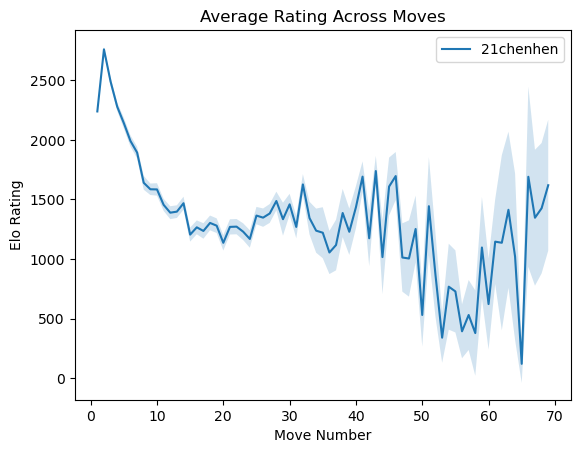

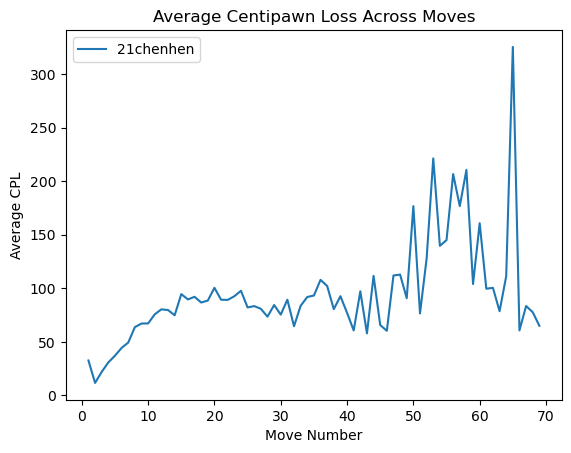

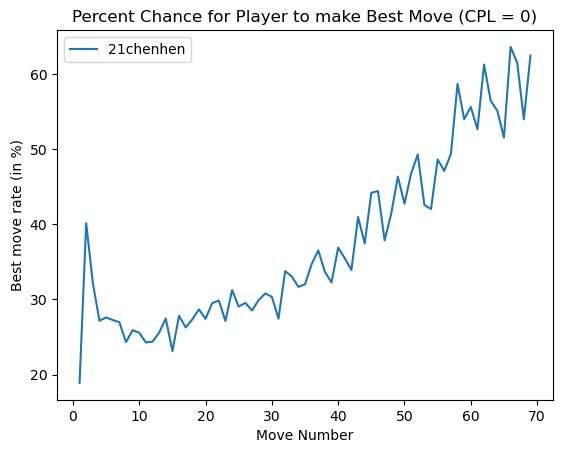

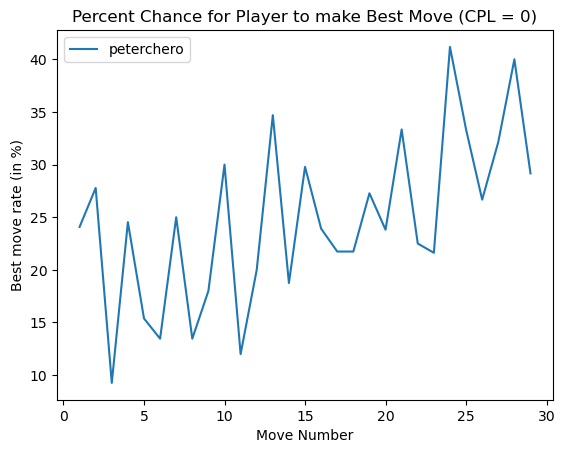

In [308]:
plotRating(70,0,henrys_moves)#,petes_moves)
plotCPL(70,0,henrys_moves)#,petes_moves)
plotBestMoveAverages(70,0,henrys_moves)
plotBestMoveAverages(30,0,petes_moves)
# plotCPL